# Feasibility and clinical utility of whole genome profiling in pediatric and young adult cancers. <br/> Shukla, Levine, Gundem et al. 

# Imports

In [12]:
%matplotlib inline
import seaborn as sns
from glob import glob
import os
from os.path import join
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mtick
from matplotlib.patches import Polygon,ConnectionPatch
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from statannot import add_stat_annotation
from matplotlib.lines import Line2D
import pandas as pd
from io import BytesIO
from io import StringIO
import numpy as np
from IPython.core.display import SVG
import math
import json
import itertools
from copy import copy
import matplotlib.transforms as transforms
from collections import defaultdict

## Plot helper

In [13]:
def display_svg(filename=None,font="Arial"):
    plt.rcParams['svg.fonttype'] = 'none'
    svg = BytesIO()
    plt.tight_layout()
    plt.savefig(svg, format="svg",bbox_inches = 'tight')
    if filename:
        plt.savefig(filename, format="svg",bbox_inches = 'tight')
    plt.close()
    svg.seek(0)
    display(SVG(svg.read().decode("utf-8").replace("font-family:DejaVu Sans",f"font-family:{font}")))

## Load Data

In [14]:
supp_tables = "../data/Shukla.Levine.Gundem Supplementary Tables.xlsx"
sup1 = pd.read_excel(supp_tables,header=1)
sup2 = pd.read_excel(supp_tables,sheet_name=1,header=1)
sup3 = pd.read_excel(supp_tables,sheet_name=2,header=1)
sup5 = pd.read_excel(supp_tables,sheet_name=4,header=1)
sup7 = pd.read_excel(supp_tables,sheet_name=6,header=1)
chromof = pd.read_csv("../data/chromothrisis_wgd.tsv",sep="\t")
cohort_rna = pd.read_csv("../data/cohort_rna.tsv",sep="\t").set_index("GENE")
nbl_types = pd.read_csv("../data/nbl_subtypes.tsv",sep=" ",names=["Individual","type"])
telomeres = pd.read_csv("../data/telomeres.tsv",sep="\t")
add_attr = pd.read_csv("../data/additional_attributes.tsv",sep="\t")
impact_muts = pd.read_csv("../data/impact_mutations.tsv",sep="\t")

In [15]:
pb = pd.read_excel(
    "../data/Grobner.data.xlsx",
    sheet_name="S_Table3",
    skiprows=2,
)
pbmedians = pb.groupby("Cancer Type")["Total Mutations Per Mb"].median()
grobnermap = {
    "WT":"Wilms Tumor",
    "ACC":"Adrenocortical Carcinoma",
    "OS":"Osteosarcoma",
    "HB":"Hepatoblastoma",
    "NB":"Neuroblastoma",
    "RB":"Retinoblastoma",
    "RMS":"Embryonal Rhabdomyosarcoma",
    "EWS":"Ewing Sarcoma",
    "BL":"Burkitt Lymphoma",
}
pedsmedian = pb.dropna(subset=["Total Mutations Per Mb"])["Total Mutations Per Mb"].median()
pbmedians.index = pbmedians.index.map(mapper=(lambda x: grobnermap.get(x,x)))

In [16]:
signatures = pd.read_csv("../data/signatures.tsv",sep="\t").set_index("Individual")
temo = ["SBS11","Temo"]
plat = ["SBS31","SBS35"]
signatures["Temo"] = signatures[temo].sum(axis=1)
signatures["Platinum"] = signatures[plat].sum(axis=1)
signatures = signatures.drop(temo[0],axis=1)
signatures = signatures.drop(plat,axis=1)
signatures = signatures[["SBS18"] + list(signatures.columns.drop("SBS18"))]
legsigs = signatures.drop(["therapy","disease"],axis=1).copy()
legsigs = legsigs[legsigs.sum(axis=1)>400]
legsigs = (legsigs.T/legsigs.sum(axis=1))
legsigs = legsigs.index[(legsigs>0.15).sum(axis=1).astype(bool)]

In [17]:
oncokbmap={'LEVEL_1': '#33A02C',
 'LEVEL_2': '#1F78B4',
 'LEVEL_2A': '#1F78B4',
 'LEVEL_2B': '#80B1D3',
 'LEVEL_3A': '#984EA3',
 'LEVEL_3B': '#BE98CE',
 'LEVEL_4': '#424242',
 'LEVEL_R1': '#EE3424',
 'LEVEL_R2': '#F79A92',
 "None":"#999999"}

# Figure 1

/juno/work/isabl/opt/python/.virtualenvs/users/levinem1/click_egreport/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


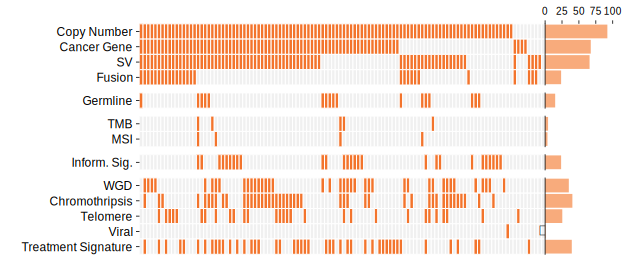

In [18]:
sup2["Inform. Sig."] = (
    sup2["Germline Signature"].fillna(0).astype(bool)
    | sup2["Signature 18 for differential Neuroblastoma diagnosis"]
    .fillna(0)
    .astype(bool)
).astype(int)
cols = [
    ["Copy Number", "Cancer Gene", "SV", "Fusion"],
    ["Germline"],
    ["TMB", "MSI"],
    ["Inform. Sig."],
    ["WGD", "Chromothripsis", "Telomere", "Viral", "Treatment Signature"],
]
f, (axes) = plt.subplots(
    len(cols),
    2,
    figsize=(8.5, 4.25),
    gridspec_kw={
        "hspace": 0.2,
        "height_ratios": [len(x) for x in cols],
        "wspace": 0,
        "width_ratios": [6, 1],
    },
)
new_bio = (
    sup2[[item for sublist in cols for item in sublist]]
    .fillna(0)
    .replace({"-": 1, "+": 1, "*": 0})
)
new_bio.columns = new_bio.columns.str.strip("_")
new_bio = new_bio.sort_values(list(new_bio.columns.values), ascending=False).T
first = True
for ax, col in zip(axes, cols):
    ax1, ax2 = ax
    sns.heatmap(
        data=new_bio.loc[[x.strip("_") for x in col]],
        square=False,
        cmap=["#F0F0F0", "#F3742C"],
        cbar=False,
        linewidths=1,
        xticklabels=True,
        yticklabels=True,
        ax=ax1,
    )
    (
        new_bio.loc[[x.strip("_") for x in col]].sum(axis=1) * 100 / new_bio.shape[1]
    ).plot.barh(width=0.9, color=["#f8ab7c"], ax=ax2)
    ax2.set_ylim(-0.5, len(col) - 0.5)
    ax2.set_xlim(0, 100)
    ax2.invert_yaxis()
    ax1.set_xticks([])
    if first:
        first = False
        ax2.xaxis.tick_top()
        ax2.xaxis.set_major_locator(MaxNLocator(4, integer=True))
    else:
        ax2.set_xticks([])
    ax2.set_yticks([])
    sns.despine(bottom=True, ax=ax2)
    plt.sca(ax1)
    plt.yticks(rotation=0, fontsize=12)
axes[-1][0].text(
    new_bio.shape[1] - 0.5, len(cols) - 1.5, "＊", ha="center", va="center", fontsize=14
)
# plt.suptitle(f"Totality of Findings (n={new_bio.shape[1]})",fontsize=14)
display_svg()

# Figure 2

(-0.5, 0.5)


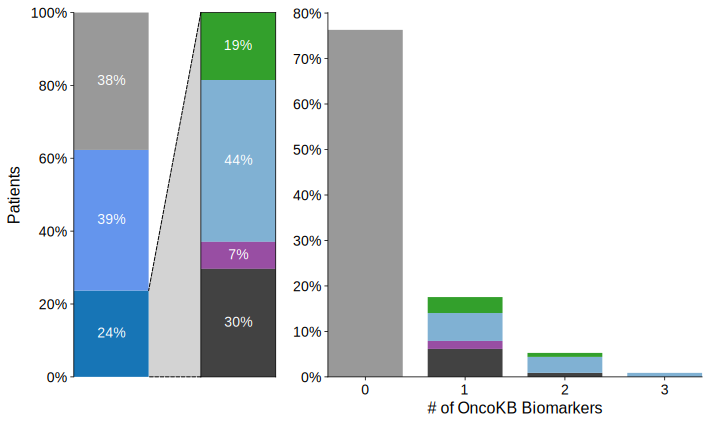

In [19]:
otiers = pd.DataFrame(index=sup1["Individual ID"].drop_duplicates())
for indiv, df in impact_muts.groupby("Individual ID"):
    df = df.copy()
    df["Highest OncoKb Sensitive Level"] = df["Highest OncoKb Sensitive Level"].replace(
        "None", np.nan
    )
    df.loc[
        df[
            df["OncoKb Oncogenicity"].str.contains(
                "onco", regex=False, case=False, na=False
            )
            & df["Highest OncoKb Sensitive Level"].isnull()
        ].index,
        "Highest OncoKb Sensitive Level",
    ] = "None"
    df = df.sort_values("Highest OncoKb Sensitive Level")
    for key, val in df["Highest OncoKb Sensitive Level"].value_counts().items():
        otiers.loc[indiv, key] = val
otiers = otiers[sorted(otiers.columns)]
otiers.fillna(0, inplace=True)
otiers["LEVEL_1"] = otiers.apply(
    lambda x: x["LEVEL_1"]
    if (x.name not in ["H135462", "H195922"])
    else x["LEVEL_1"] + 1,
    axis=1,
)  # TMB/MSI Treatment

total = otiers.shape[0]
drug = otiers.drop("None", axis=1).sum(axis=1).astype(bool).value_counts()[True]
oncocount = (
    otiers["None"].astype(bool) & ~otiers.drop("None", axis=1).sum(axis=1).astype(bool)
).sum()
none = total - drug - oncocount
fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(10, 6), gridspec_kw={"width_ratios": [1, 1, 5]}
)
(
    pd.Series(
        [drug, oncocount, none], index=["Therapy Informing", "Oncogenic", "No"]
    ).to_frame()
    / otiers.shape[0]
    * 100
).T.plot.bar(
    stacked=True, width=1, ax=ax1, color=["#1775b6", "#6495ED", "#999999"], legend=False
)
ax1.set_ylabel("Patients", fontsize=16)
sns.despine(bottom=True, ax=ax1)
ax1.set_xticks([])
ax1.set_xlim(-0.5, 0.5)
ax1.tick_params(axis="y", which="major", labelsize=14)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
rects = ax1.patches
for rect in rects:
    percent = rect.get_height() / 100  # /tiers.shape[0]
    ax1.text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_y() + rect.get_height() / 2,
        "{:1.0%}".format(percent),
        ha="center",
        va="center",
        color="white",
        fontsize=14,
    )
ax1.set_ylim(0, 100)


def highest_tier(row):
    for key in row.keys():
        if row[key] > 0:
            return key


highest = (
    otiers[otiers.drop("None", axis=1).sum(axis=1).astype(bool)]
    .apply(highest_tier, axis=1)
    .value_counts()
)
colors = highest.sort_index().index.to_series().replace(oncokbmap).to_list()
highest.to_frame().sort_index().T.plot.bar(
    stacked=True, width=1, color=colors, ax=ax2, legend=False
)
ax2.set_xticks([])
ax2.set_xlim(-0.5, 0.5)
ax2.set_ylim(0, highest.sum())
ax2.set_yticks([])
ax2.invert_yaxis()
rects = ax2.patches
for rect in rects:
    percent = rect.get_height() / highest.sum()
    ax2.text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_y() + rect.get_height() / 2,
        "{:1.0%}".format(percent),
        ha="center",
        va="center",
        color="white",
        fontsize=14,
    )
width = 0.75
tiers = otiers.drop("None", axis=1)
tier_count = tiers.sum(axis=1).astype(int).to_frame(name="count")
tier_count["highest"] = tiers.apply(highest_tier, axis=1)
tier_count = (
    tier_count.fillna("None")
    .groupby(["highest", "count"])
    .size()
    .reset_index()
    .pivot(columns="highest", index="count", values=0)
    / tiers.shape[0]
    * 100
)
tier_count[reversed(tier_count.columns)].plot.bar(
    stacked=True,
    color=["#999999"]
    + tier_count.columns[:-1][::-1].to_series().replace(oncokbmap).to_list(),
    width=width,
    ax=ax3,
    legend=False,
)
sns.despine(ax=ax3)
plt.xticks(rotation="horizontal")
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel("# of OncoKB Biomarkers", fontsize=16)
plt.xlim(-width / 2, tier_count.shape[0] - 1 + width / 2)
ax3.tick_params(axis="x", which="major", labelsize=14)
ax3.tick_params(axis="y", which="major", labelsize=14)
# zoom area
plt.tight_layout()
ax0tr = ax1.transData
ax1tr = ax2.transAxes
figtr = fig.transFigure.inverted()
print(ax1.get_xlim())
ptA = figtr.transform(ax0tr.transform((0.5, 0)))
ptB = figtr.transform(ax0tr.transform((0.5, highest.sum() / otiers.shape[0] * 100)))
ptD = figtr.transform(ax1tr.transform((0, 0)))
ptC = figtr.transform(ax1tr.transform((0, 1)))
poly = Polygon(
    [ptA, ptB, ptC, ptD],
    closed=True,
    fc="lightgray",
    transform=fig.transFigure,
    zorder=0,
)
fig.patches.append(poly)
# zoom lines
con = ConnectionPatch(
    xyA=(0, 1),
    xyB=(0.5, drug / otiers.shape[0] * 100),
    coordsA="axes fraction",
    coordsB="data",
    axesA=ax2,
    axesB=ax1,
    linestyle="--",
)
fig.add_artist(con)
con = ConnectionPatch(
    xyA=(0, 0),
    xyB=(0.5, 0),
    coordsA="axes fraction",
    coordsB="data",
    axesA=ax2,
    axesB=ax1,
    linestyle="--",
)
fig.add_artist(con)
display_svg()

/juno/work/isabl/opt/python/.virtualenvs/users/levinem1/click_egreport/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


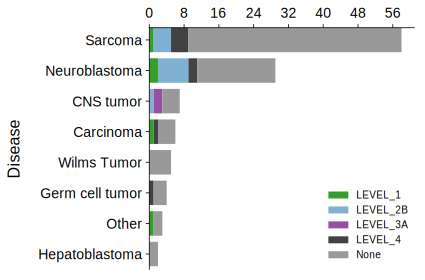

In [20]:
tier_count = tiers.sum(axis=1).astype(int).to_frame(name="count")
tier_count["highest"] = tiers.apply(highest_tier, axis=1)
disease_map = sup1[["Individual ID", "Disease Category"]]
disease_map.drop_duplicates(inplace=True)
disease_map.set_index("Individual ID", inplace=True)
tier_count = (
    tier_count.join(disease_map)
    .fillna("None")
    .groupby(["highest", "Disease Category"])
    .size()
    .reset_index()
    .pivot(columns="highest", index="Disease Category", values=0)
    .fillna(0)
)
tier_count = (
    tier_count.assign(sum=tier_count.sum(axis=1))
    .sort_values(by="sum", ascending=True)
    .iloc[:, :-1]
)
ax = tier_count.plot(
    kind="barh",
    stacked=True,
    width=0.8,
    color=tier_count.columns.to_series().replace(oncokbmap),
)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(labelbottom=False, labeltop=True)
sns.despine(bottom=True, top=False)
plt.legend(frameon=False)
ax.tick_params(axis="x", which="major", labelsize=14)
ax.tick_params(axis="y", which="major", labelsize=14)
plt.ylim(-0.5, ax.get_ylim()[1] - 0.25)
plt.ylabel("Disease", fontsize=16)
display_svg()

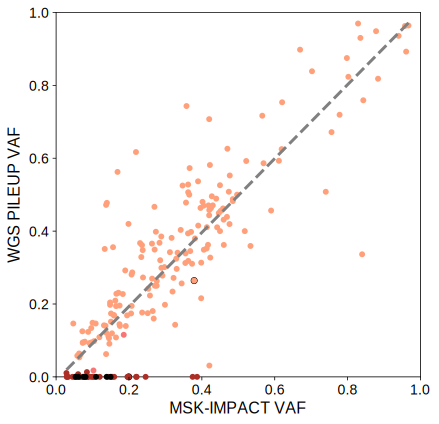

In [21]:
plt.figure(figsize=(8, 6))
df = sup3.copy().dropna(subset=["WGS PILEUP VAF"]).sort_values("IMPACT VAF")
regr = linear_model.LinearRegression()
regr.fit(pd.DataFrame(df["IMPACT VAF"]), pd.DataFrame(df["WGS PILEUP VAF"]))
vaf_pred = regr.predict(pd.DataFrame(df["IMPACT VAF"]))
df.loc[
    (df["ITH Status"] == "Predicted ITH")
    & (df["Prop Test Corrected by Tumor purity"] >= 0.05),
    "ITH Status",
] = "Low Cov"
df["Call Status"] = pd.Categorical(
    df["ITH Status"].replace(
        {"Predicted ITH": "ITH", "Missed": "Filtered", "Confirmed ITH": "ITH"}
    ),
    ["Both", "ITH", "Low Cov", "Filtered"],
    ordered=True,
)
impact_only = df[~df["Called in WGS"].fillna(False).astype(bool)]
both = df[df["Called in WGS"].fillna(False).astype(bool)]
ith = df[df["Call Status"] == "ITH"]
low = df[df["Call Status"] == "Low Cov"]
filtered = df[df["Call Status"] == "Filtered"]
plt.scatter(
    both["IMPACT VAF"],
    both["WGS PILEUP VAF"],
    color="#FFA07A",
    linewidth=0,
    clip_on=False,
)
plt.scatter(
    ith["IMPACT VAF"],
    ith["WGS PILEUP VAF"],
    color="#AD2E24",
    linewidth=0,
    clip_on=False,
)
plt.scatter(
    low["IMPACT VAF"], low["WGS PILEUP VAF"], color="blacK", linewidth=0, clip_on=False
)
plt.scatter(
    filtered["IMPACT VAF"],
    filtered["WGS PILEUP VAF"],
    color="#F87575",
    linewidth=0,
    clip_on=False,
)
plt.scatter(
    df[df["Individual ID"] == "H133675"]["IMPACT VAF"],
    df[df["Individual ID"] == "H133675"]["WGS PILEUP VAF"],
    color="black",
    lw=1,
    clip_on=False,
    zorder=0,
)
ax = plt.gca()
ax.plot(
    df["IMPACT VAF"].iloc[[0, -1]],
    vaf_pred[[0, -1]],
    color="gray",
    linewidth=3,
    linestyle="--",
)
ax.set_aspect("equal")
ax.tick_params(axis="x", which="major", labelsize=14)
ax.tick_params(axis="y", which="major", labelsize=14)
plt.xlabel("MSK-IMPACT VAF", fontsize=16)
plt.ylabel("WGS PILEUP VAF", fontsize=16)
plt.xlim(0, 1)
plt.ylim(0, 1)
for k, spine in ax.spines.items():  # ax.spines is a dictionary
    spine.set_zorder(-10)
display_svg()

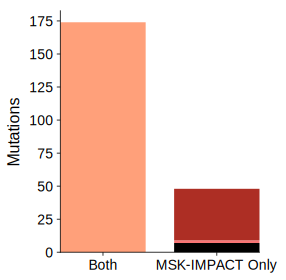

In [22]:
width = 0.75
df = sup3.copy().sort_values("IMPACT VAF")
df.loc[
    (df["ITH Status"] == "Predicted ITH")
    & (df["Prop Test Corrected by Tumor purity"] >= 0.05),
    "ITH Status",
] = "Low Cov"
df["Call Status"] = pd.Categorical(
    df["ITH Status"].replace(
        {"Predicted ITH": "ITH", "Missed": "Filtered", "Confirmed ITH": "ITH"}
    ),
    ["Both", "ITH", "Low Cov", "Filtered"],
    ordered=True,
)
impact_only = df[~df["Called in WGS"].fillna(False).astype(bool)]
both = df[df["Called in WGS"].fillna(False).astype(bool)]
ith = df[df["Call Status"] == "ITH"]
low = df[df["Call Status"] == "Low Cov"]
filtered = df[df["Call Status"] == "Filtered"]
# to_plot = pd.DataFrame([[non_complx.shape[0],0,0],[0,missed.shape[0],not_detected.shape[0]]],index=["Both","IMPACT Only"],columns=["Both","Missed","Predicted heterozygosity"])
to_plot = pd.DataFrame([[both.shape[0],0,0],[0,low.shape[0],filtered.shape[0],ith.shape[0]]],index=["Both","MSK-IMPACT Only"],columns=[f"Both (n={both.shape[0]})",f"Missed (n={filtered.shape[0]})",f"Predicted heterogeneity (n={ith.shape[0]})",f"Confirmed heterogeneity (n={low.shape[0]})"])
ax = to_plot.plot.bar(stacked=True,width=width,figsize=(4,4),color=["#FFA07A","black","#F87575","#AD2E24"],legend=False)
plt.ylabel("Mutations", fontsize=16)
plt.xticks(rotation='horizontal')
sns.despine()
plt.xlim(-width/2,2-1+width/2)
ax.tick_params(axis='x', which='major', labelsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)
display_svg()

/juno/work/isabl/opt/python/.virtualenvs/users/levinem1/click_egreport/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/juno/work/isabl/opt/python/.virtualenvs/users/levinem1/click_egreport/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


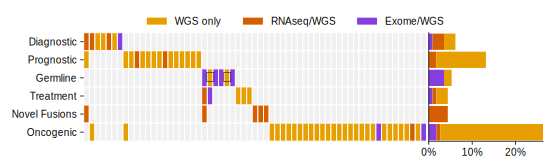

In [23]:
new_bio = sup2[["Individual ID",'Informs Diagnosis','Prognostic Findings','Germline Signature.1','Therapy Defining','Novel Fusions','Other Oncogenic Event']].set_index("Individual ID").fillna(0)
new_bio.rename(columns={'Informs Diagnosis':"Diagnostic",'Prognostic Findings':"Prognostic",'Germline Signature.1':"Germline",'Therapy Defining':"Treatment",'Other Oncogenic Event':"Oncogenic"},inplace=True)
new_bio.columns = new_bio.columns.str.title()
stars = new_bio[new_bio["Germline"]=="1*"].index
new_bio=new_bio.replace({"1*":1}).astype(int)

wgs_findings = new_bio.copy()
exome_findings = wgs_findings.copy()
exome_findings[exome_findings!=0] = 0
rna_findings = exome_findings.copy()
exome_findings.loc["H135466","Treatment"] = 1
exome_findings.loc["H197215","Diagnostic"] = 1
exome_findings.loc["H198662","Oncogenic"] = 1
exome_findings.loc["H156418","Germline"] = 1
exome_findings.loc["H136573","Germline"] = 1
exome_findings.loc["H134757","Germline"] = 1
exome_findings.loc["H135076","Germline"] = 1
exome_findings.loc["H195989","Oncogenic"] = 1
for event in ["H136134","H195922"]:
    rna_findings.loc[event,"Prognostic"] = 1
for event in ["H135066","H108333"]:
    rna_findings.loc[event,"Diagnostic"] = 1
rna_findings.loc["H196848","Oncogenic"] = 1
rna_findings.loc["H156418",["Novel Fusions","Treatment"]] = 1
rna_findings.loc["H134768",["Novel Fusions","Diagnostic"]] = 1
for fus in ["H133672","H134756","H135459"]:
    rna_findings.loc[fus,"Novel Fusions"] = 1
    
new_bio=new_bio.replace({1:2}).where((new_bio & rna_findings).astype(bool),new_bio)
new_bio=new_bio.replace({1:3}).where((new_bio & exome_findings).astype(bool),new_bio)
to_plot = new_bio.loc[new_bio[new_bio.sum(axis=1)>0].replace({2:1,3:1}).sort_values(list(new_bio.columns.values),ascending=False).index]
# to_plot = new_bio[new_bio.sum(axis=1)>0].replace({2:1,3:1}).sort_values(list(new_bio.columns.values),ascending=False)
annot = to_plot.copy()
annot[annot!=""]=""
annot.loc[stars,"Germline"]="＊"
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8.25,2),gridspec_kw={'width_ratios': [3, 1],"wspace":0.01})
sns.heatmap(data=to_plot.T,square=False,cmap=["#F0F0F0","#E79F00","#D55E00","#873EE0"],
               cbar=False,linewidths=1,xticklabels=False, yticklabels=True,ax=ax1,annot=annot.T,fmt = '',annot_kws={"fontsize":14,"color":"black"})
ax1.set_xlabel(None)
plt.yticks(fontsize=10)

barside = exome_findings.sum().to_frame("WES")
barside = barside.join((rna_findings.astype(bool) & ~exome_findings.astype(bool)).sum().rename("RNA-seq"))
barside = barside.join((wgs_findings.astype(bool) & (~exome_findings.astype(bool) & ~rna_findings.astype(bool))).sum().rename("WGS only"))
barside = barside/exome_findings.shape[0]*100
barside.plot.barh(stacked=True,width=0.9,edgecolor="black",lw=0,color=reversed(["#E79F00","#D55E00","#873EE0"]),ax=ax2,legend=False)

sns.despine(ax=ax2)
ax2.set_ylim(-0.5,len(new_bio.columns)-0.5)
ax2.invert_yaxis()
ax2.set_yticks([])
ax2.set_xlim(0,barside.sum(axis=1).max())
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
plt.xticks(fontsize=10)
from matplotlib.patches import Patch
handles = [Patch(facecolor=x) for x in ["#E79F00","#D55E00","#873EE0"]]
# ax1.legend(handles=handles,labels=["WGS only","WGS/RNAseq","RNAseq only"],loc="center left",bbox_to_anchor=(1,0.5),frameon=False, fontsize=12)
fig.legend(handles=handles,labels=["WGS only","RNAseq/WGS","Exome/WGS"], ncol=3,loc="lower center",bbox_to_anchor=(0.5,0.9),frameon=False, fontsize=10)
display_svg()

# Figure 3

In [24]:
def expr_plot(
    gene,
    selected,
    selected_color="#F3742C",
    cohort_color="#97BFFF",
    mut_type="Rearranged",
    salmon=cohort_rna,
):
    selected = sup1[sup1["Individual ID"].isin(selected)]["RNA ID"].dropna().to_list()
    plt.figure(figsize=(2, 5))
    sns.boxplot(y=salmon.loc[gene, salmon.columns.drop(selected)], color=cohort_color)
    plt.yscale("symlog")
    sns.swarmplot(y=salmon.loc[gene][selected], color=selected_color, size=10)
    legend_elements = [
        Line2D(
            [0],
            [0],
            markerfacecolor=selected_color,
            markersize=10,
            marker="o",
            label=f"{gene} {mut_type}",
            linewidth=0,
            mew=0,
        ),
        Line2D(
            [0],
            [0],
            markerfacecolor=cohort_color,
            markersize=15,
            marker="s",
            label="Cohort",
            linewidth=0,
            mew=0,
        ),
    ]
    plt.legend(
        handles=legend_elements,
        frameon=False,
        fontsize=12,
        title_fontsize=14,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
    )
    plt.title(f"{gene} expression across n={salmon.shape[1]}", fontsize=14)
    plt.gca().tick_params(axis="y", which="major", labelsize=14)
    plt.ylabel(f"{gene} TPM", fontsize=12)
    sns.despine()
    plt.setp(plt.gca().spines.values(), linewidth=1)
    display_svg()

/juno/work/isabl/opt/python/.virtualenvs/users/levinem1/click_egreport/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


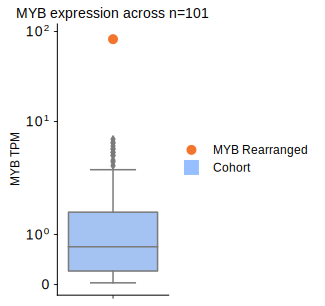

In [25]:
expr_plot("MYB",["H133676"])

In [26]:
gene_structures = pd.read_csv("/work/isabl/home/levinem1/refFlat.sorted.bed.gz",sep="\t",header=None)

/juno/work/isabl/opt/python/.virtualenvs/users/levinem1/click_egreport/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


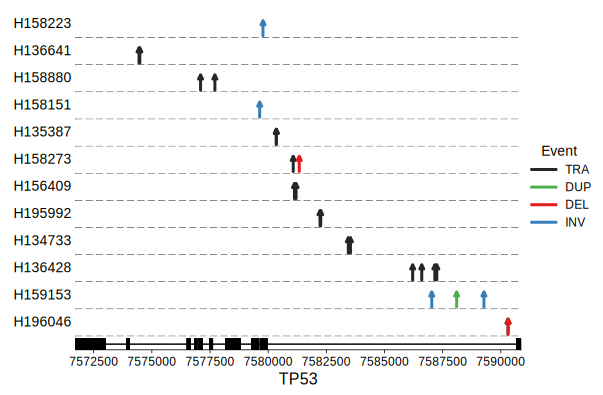

In [27]:
gene = "TP53"
arcs = False
yticks = False
show_cn = False
gene_structure = gene_structures[gene_structures[3] == gene]
gene_chrom = gene_structure.iloc[0, 0]
gene_min = gene_structure[1].min()
gene_max = gene_structure[2].max()
rear_color = {
    "TRA": (38 / 255, 38 / 255, 38 / 255),
    "DUP": (77 / 255, 175 / 255, 74 / 255),
    "DEL": (228 / 255, 26 / 255, 28 / 255),
    "INV": (55 / 255, 126 / 255, 184 / 255),
}

rearrs = sup7[(sup7["GENE1"] == gene) | (sup7["GENE2"] == gene)].copy()
for i, row in rearrs.iterrows():
    if row["CHR1"] == row["CHR2"]:
        continue
    if str(row["CHR1"]) == str(gene_chrom):
        continue
    tmp = (row.GENE1, row.CHR1, row.POS1)
    (row.GENE1, row.CHR1, row.POS1) = (row.GENE2, row.CHR2, row.POS2)
    (row.GENE2, row.CHR2, row.POS2) = tmp
    rearrs.loc[i] = row
rearrs.sort_values("POS1", inplace=True)

indivs = rearrs["Individual ID"].unique()
fig, (axes) = plt.subplots(
    len(indivs) + 1,
    1,
    figsize=(8, (len(indivs) + 0.5) / 2),
    sharex=True,
    gridspec_kw={"hspace": 0, "height_ratios": [4] * len(indivs) + [2]},
)
for ax, (indiv, df) in zip(axes, rearrs.groupby("Individual ID", sort=False)):
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    if show_cn:
        results = {}
        for result in df.iloc[0]["Experiment"].results:
            if result.status not in ["IN_PROGRESS", "SUCCEEDED"]:
                continue
            results[result.application.name] = result
        chunks = pd.read_csv(
            results["BRASS"].results.cn_reg,
            sep="\t",
            names=["CHR", "START", "END", "CN", "RAW"],
            low_memory=False,
            chunksize=20000,
        )
        cn = []
        for i in chunks:
            cn.append(
                i[
                    (i["CHR"].astype(str) == gene_chrom)
                    & i["START"].between(gene_min, gene_max)
                ]
            )
        cn = pd.concat(cn)
        cn["Mid"] = (cn["START"].astype(int) + cn["END"].astype(int)) / 2
        cn.plot.scatter(x="Mid", y="CN", color="lightgray", ax=ax, s=4)
    if yticks:
        ax.yaxis.tick_right()
    else:
        ax.set_yticks([])
    ax.spines["bottom"].set_linestyle((0, (8, 5)))
    ax.set_ylabel(indiv, rotation=0, ha="right", va="center", fontsize=14)
    for _, row in df.iterrows():
        ax.annotate(
            "",
            xy=(row["POS1"], 0.75),
            xycoords=trans,
            textcoords=trans,
            xytext=(row["POS1"], 0),
            arrowprops=dict(
                color=rear_color[row["SVTYPE"]], arrowstyle="->", lw=3, shrinkB=0
            ),
            clip_on=True,
        )
        if row["SVTYPE"] != "TRA":
            ax.annotate(
                "",
                xy=(row["POS2"], 0.75),
                xycoords=trans,
                textcoords=trans,
                xytext=(row["POS2"], 0),
                arrowprops=dict(
                    color=rear_color[row["SVTYPE"]], arrowstyle="->", lw=3, shrinkB=0
                ),
                clip_on=True,
            )
            if arcs:
                ax.add_artist(
                    matplotlib.patches.FancyArrowPatch(
                        (row["POS1"], 0.7),
                        (row["POS2"], 0.7),
                        transform=trans,
                        color=rear_color[row["SVTYPE"]],
                        connectionstyle="arc3,rad=-.075",
                        shrinkA=0,
                        shrinkB=0,
                    )
                )
sns.despine(left=True)
from matplotlib.lines import Line2D

if yticks:
    legspace = 1.1
else:
    legspace = 1
axes[int(len(indivs) / 2)].legend(
    [Line2D([0], [0], color=x, lw=3) for x in rear_color.values()],
    rear_color.keys(),
    title="Event",
    frameon=False,
    fontsize=12,
    title_fontsize=14,
    loc="center left",
    bbox_to_anchor=(legspace, 0.5),
)
for _, iso in gene_structure.iterrows():
    starts = [iso[1] + int(x) for x in iso[11].strip(",").split(",")]
    lengths = [int(x) for x in iso[10].strip(",").split(",")]
    plt.broken_barh(list(zip(starts, lengths)), [-1, 2], color="black")
plt.plot([gene_min, gene_max], [0, 0], color="black")
plt.ylim(-1, 1.4)
plt.yticks([])
plt.xticks(fontsize=12)
plt.xlabel(gene, fontsize=16)
plt.xlim(gene_min, gene_max)
display_svg()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

TP53 Rearranged v.s. No Rearrangement: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.645e-03 U_stat=1.900e+01


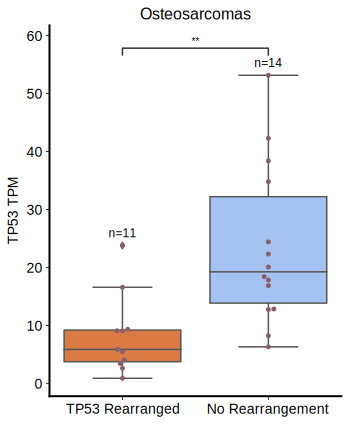

In [28]:
os_has_rna = sup1.loc[sup1[sup1["Disease"] == "Osteosarcoma"]["RNA ID"].dropna().index]
selected = sup7[((sup7["GENE1"] == "TP53") | (sup7["GENE2"] == "TP53"))][
    "Individual ID"
].drop_duplicates().to_list() + ["H158919"]
altered = os_has_rna[os_has_rna["Individual ID"].isin(selected)]
other = os_has_rna[os_has_rna["Disease"] == "Osteosarcoma"].drop(altered.index)
altered = altered["RNA ID"].dropna().to_list()
other = other["RNA ID"].dropna().to_list()
altered = cohort_rna.loc["TP53", altered].to_frame()
altered["Altered"] = "TP53 Rearranged"
other = cohort_rna.loc["TP53", other].to_frame()
other["Altered"] = "No Rearrangement"
all_tp53 = pd.concat([altered, other]).sort_values("TP53")
plt.figure(figsize=(5, 6))
order = ["TP53 Rearranged", "No Rearrangement"]
ax = sns.boxplot(
    data=all_tp53, x="Altered", y="TP53", palette=["#F3742C", "#97BFFF"], order=order
)
sns.swarmplot(data=all_tp53, x="Altered", y="TP53", color="#8B5F65", ax=ax, order=order)
sns.despine()
ax.tick_params(axis="x", which="major", labelsize=14)
ax.tick_params(axis="y", which="major", labelsize=14)
plt.setp(ax.spines.values(), linewidth=2)
plt.ylabel("TP53 TPM", fontsize=14)
plt.xlabel("")
plt.title("Osteosarcomas", fontsize=16)
plt.text(
    x=0,
    y=altered["TP53"].max() + 1,
    s=f"n={altered.shape[0]}",
    va="bottom",
    ha="center",
    fontsize=12,
)
plt.text(
    x=1,
    y=other["TP53"].max() + 1,
    s=f"n={other.shape[0]}",
    va="bottom",
    ha="center",
    fontsize=12,
)
test = add_stat_annotation(
    ax,
    data=all_tp53,
    x="Altered",
    y="TP53",
    order=order,
    box_pairs=[tuple(order)],
    test="Mann-Whitney",
    text_format="star",
    loc="inside",
    verbose=2,
)
display_svg()

# Figure 5

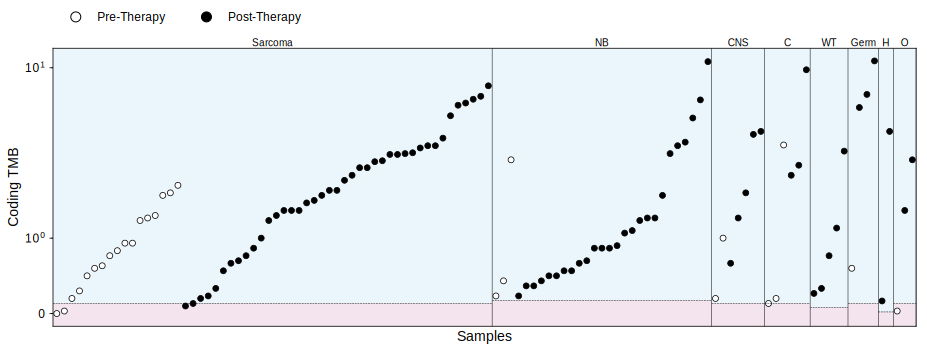

In [29]:
data = add_attr.copy()
data["disease"] = data["Disease Category"].str.title()
data["disease"] = pd.Categorical(
    data["disease"],
    categories=list(data["disease"].value_counts().drop("Other").index.values)
    + ["Other"],
    ordered=True,
)
data = data.sort_values(
    ["disease", "therapy", "Coding TMB"], ascending=[True, False, True]
)
plt.figure(figsize=(13, 5))
ax = sns.scatterplot(
    data=data, x="Individual", y="Coding TMB", edgecolor="black", clip_on=False
)
plt.yscale("symlog")
ax.collections[0].set_facecolors(
    ["white" if x == "PRE-THERAPY" else "black" for x in data["therapy"].values]
)
count = -0.5
trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
for disease, i in list(
    data.drop_duplicates("Individual").groupby("disease", sort=False).size().items()
):
    ldisease = {
        "Osteosarcoma": "OS",
        "Neuroblastoma": "NB",
        "Undifferentiated Sarcoma": "U. Sarcoma",
        "Embryonal Rhabdomyosarcoma": "RMS",
        "Wilms Tumor": "WT",
        "Ewing Sarcoma": "EWS",
        "Cns Tumor": "CNS",
        "Hepatoblastoma": "H",
        "Other": "O",
        "Germ Cell Tumor": "Germ",
        "Carcinoma": "C",
    }.get(disease, disease)
    plt.text(
        x=count + i / 2, y=1, s=ldisease, transform=trans, ha="center", va="bottom"
    )
    if disease in pbmedians.index.values:
        median = pbmedians.loc[disease]
    else:
        median = pedsmedian
    ax.add_artist(
        mpatches.Rectangle(
            (count, ax.get_ylim()[0]),
            i,
            abs(ax.get_ylim()[0]) + median,
            facecolor="#CC79A7",
            alpha=0.2,
            zorder=0,
        )
    )
    ax.add_artist(
        mpatches.Rectangle(
            (count, median),
            i,
            ax.get_ylim()[1] - median,
            facecolor="#9AD0F3",
            alpha=0.2,
            zorder=0,
        )
    )
    ax.hlines(median, xmin=count, xmax=count + i, color="black", linestyle="--", lw=0.5)
    count += i
    ax.axvline(count, color="black", lw=0.5)
plt.xticks([])
plt.gca().tick_params(axis="y", which="major", labelsize=12)
plt.xlabel("Samples", fontsize=14)
plt.ylabel("Coding TMB", fontsize=14)
plt.xlim(-0.5, data.drop_duplicates("Individual").shape[0] - 0.5)
from matplotlib.lines import Line2D

handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="white",
        markeredgecolor="black",
        markersize=10,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="black",
        markeredgecolor="black",
        markersize=10,
    ),
]
plt.legend(
    ncol=2,
    loc="lower left",
    handles=handles,
    labels=["Pre-Therapy", "Post-Therapy"],
    bbox_to_anchor=(0, 1.05),
    frameon=False,
    fontsize=12,
)
display_svg()

/juno/work/isabl/opt/python/.virtualenvs/users/levinem1/click_egreport/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/juno/work/isabl/opt/python/.virtualenvs/users/levinem1/click_egreport/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/juno/work/isabl/opt/python/.virtualenvs/users/levinem1/click_egreport/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be se

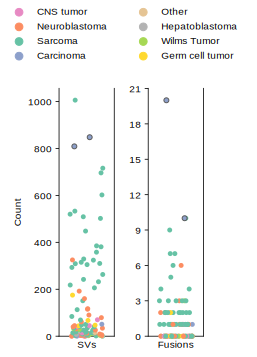

In [30]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(3,4))
with_rna = add_attr.dropna(subset=["Fusions"])
with_rna.sort_values("REARR",inplace=True)
cmap = dict(zip(with_rna["Disease Category"].value_counts().index,sns.color_palette("Set2")))
with_rna["placeholder"]=""
with_rna.loc[with_rna["Individual"]=="H135462","Fusions"] = 10 #low reads minimum by clonality
sns.stripplot(data=with_rna,x="placeholder",y="REARR", linewidth=with_rna["Individual"].isin(["H135022","H135462"]), ax=ax1, hue="Disease Category",palette=cmap, jitter=0.3,clip_on=False)
sns.stripplot(data=with_rna,x="placeholder",y="Fusions",linewidth=with_rna["Individual"].isin(["H135022","H135462"]), ax=ax2, hue="Disease Category",palette=cmap, jitter=0.3,clip_on=False)
ax1.get_legend().remove()
handles, labels = ax2.get_legend_handles_labels()
f.legend(handles[1:], labels[1:],frameon=False, loc="lower left",bbox_to_anchor=(0, 1),ncol=2)
ax2.get_legend().remove()
sns.despine(ax=ax1,right=False)
sns.despine(ax=ax2,right=False)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xticks([])
ax2.set_xticks([])
ax1.set_ylim(0,)
ax2.set_ylim(0,)
ax1.set_ylabel("Count",fontsize=10)
ax2.set_ylabel("")
ax1.set_xlabel("SVs",fontsize=10)
ax2.set_xlabel("Fusions",fontsize=10)
display_svg()

# Supplemental Figure 1

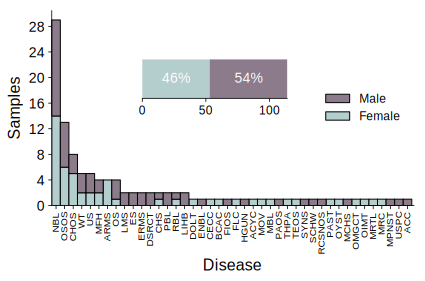

In [31]:
colors = ["#B4CDCD", "#8B7B8B"]
genders = add_attr.groupby("disease.acronym")["gender"].value_counts().unstack()
genders = genders.loc[genders.sum(axis=1).sort_values(ascending=False).index]
genders.columns = genders.columns.str.title()
genders.fillna(0).plot(kind="bar", stacked=True, width=1, ec="black", color=colors)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlim(-0.5)
sns.despine()
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles=handles[::-1],
    labels=labels[::-1],
    loc="center right",
    frameon=False,
    fontsize=12,
)
inset = plt.gca().inset_axes([0.25, 0.55, 0.4, 0.2])
plt.xlabel("Disease", fontsize=16)
plt.ylabel("Samples", fontsize=16)
plt.gca().tick_params(axis="x", which="major", labelsize=10)
plt.gca().tick_params(axis="y", which="major", labelsize=14)
genders.sum().to_frame().T.plot.barh(
    stacked=True, width=1, legend=False, ax=inset, color=colors
)
sns.despine(left=True, ax=inset)
inset.set_yticks([])
inset.set_ylim(-0.1, 0.1)
inset.set_xlim(0, genders.sum().sum())
inset.tick_params(axis="x", which="major", labelsize=12)
# plt.legend(loc="center left",bbox_to_anchor=(1.1, 0.5),frameon=False)
rects = inset.patches
for rect in rects:
    percent = rect.get_width() / genders.sum().sum()
    inset.text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_y() + rect.get_height() / 2,
        "{:1.0%}".format(percent),
        ha="center",
        va="center",
        color="white",
        fontsize=14,
    )
display_svg()

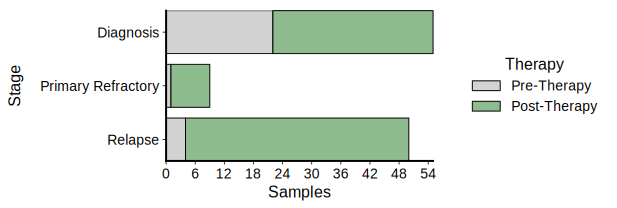

In [32]:
width = 0.8
colors = ["lightgrey","darkseagreen"]
data = sup1.groupby(['Stage', 'Therapy']).size().sort_index(ascending=[False,True]).reset_index().pivot(columns='Therapy', index='Stage', values=0)[["PRE-THERAPY","POST-THERAPY"]]
data.columns = data.columns.str.title()
data.index = data.index.str.title()
ax = data.sort_index(ascending=False).plot.barh(stacked=True,width=width,figsize=(9,3),lw=1,ec="black",color=colors)
plt.legend(loc="center left",bbox_to_anchor=(1.1, 0.5),frameon=False, title="Therapy",fontsize=14,title_fontsize=16)
plt.ylim(-width/2,data.shape[0]-1+width/2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='x', which='major', labelsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)
plt.xlim(0,data.sum(axis=1).max())
sns.despine()
plt.setp(ax.spines.values(), linewidth=2)
plt.xlabel("Samples",fontsize=16)
plt.ylabel("Stage",fontsize=16)
display_svg()

/juno/work/isabl/opt/python/.virtualenvs/users/levinem1/click_egreport/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


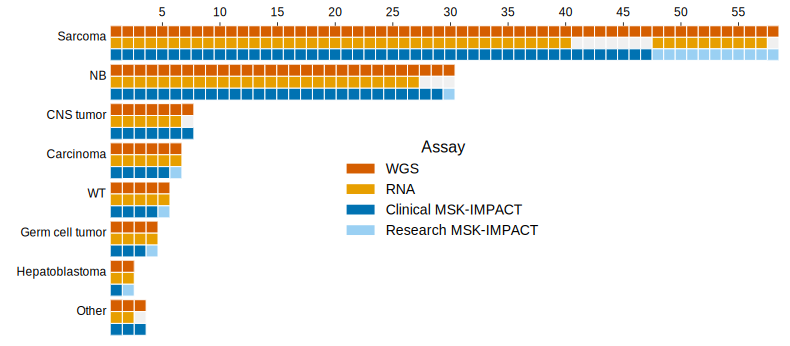

In [33]:
data = sup1[["DNA ID","RNA ID","Matched Clinical IMPACT.1","Matched Research IMPACT.1","Disease Category"]].copy()
num_groups = len(data["Disease Category"].unique())
f,(axes) = plt.subplots(num_groups,1,figsize=(12,num_groups/1.4),gridspec_kw={"hspace":0.1})
data["DNA ID"] = (~data["DNA ID"].isna()).replace({False:0,True:1}).astype(int)
data["RNA ID"] = (~data["RNA ID"].isna()).replace({False:0,True:2}).astype(int)
data["Matched Clinical IMPACT.1"] = data["Matched Clinical IMPACT.1"].replace({False:0,True:3}).astype(int)
data.loc[(~data["Matched Clinical IMPACT.1"])&(data["Matched Research IMPACT.1"]),"Matched Clinical IMPACT.1"] = 4
data.drop("Matched Research IMPACT.1",axis=1,inplace=True)
data.columns = ["WGS","RNA","Matched IMPACT", "Disease"]
for i,(group, df) in enumerate(sorted(data.groupby("Disease"),key=lambda x: len(x[1]) if x[0]!="Other" else 0,reverse=True)):
    sns.heatmap(data=df.sort_values(by=[ "Matched IMPACT","WGS","RNA"],ascending=[True,False,False]).drop("Disease",axis=1).T,cmap=["#F0F0F0","#D55E00","#E79F00","#0072B2","#9AD0F3"],cbar=False,square=True,linewidths=1,xticklabels=False, yticklabels=False,ax=axes[i],vmin=0,vmax=4)
    ldisease = {"Osteosarcoma":"OS","Neuroblastoma":"NB","Undifferentiated Sarcoma":"U. Sarcoma","Embryonal Rhabdomyosarcoma":"RMS","Wilms Tumor":"WT","Ewing Sarcoma":"EWS"}.get(group,group)
    axes[i].set_ylabel(ldisease,fontsize=12,rotation=0,ha="right")
for ax in axes:
    ax.set_anchor('W')
from matplotlib.patches import Patch
handles = [Patch(facecolor=x) for x in ["#D55E00","#E79F00","#0072B2","#9AD0F3"]]
axes[0].legend(handles=handles,labels=["WGS","RNA","Clinical MSK-IMPACT", "Research MSK-IMPACT"],loc="lower center",bbox_to_anchor=(0.5, -5.5),frameon=False, title="Assay",fontsize=14,title_fontsize=16)
axes[0].xaxis.tick_top()
axes[0].xaxis.set_ticks(np.arange(5, axes[0].get_xlim()[1], 5)-0.5)
axes[0].set_xticklabels(np.arange(5, axes[0].get_xlim()[1], 5).astype(int),fontsize=12)
display_svg()

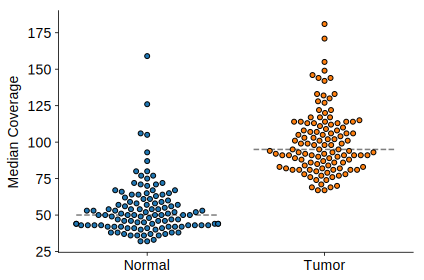

In [34]:
ax = sns.swarmplot(
    data=add_attr.melt(value_vars=["Coverage", "Normal Coverage"])
    .replace({"Coverage": "Tumor", "Normal Coverage": "Normal"})
    .sort_values("variable"),
    x="variable",
    y="value",
    edgecolor="black",
    linewidth=1,
    dodge=False,
)
sns.despine()
plt.ylabel("Median Coverage", fontsize=14)
plt.xlabel("")
ax.set_xticklabels([x.get_text().split("_")[0].title() for x in ax.get_xticklabels()])
for i, (variable, value) in enumerate(
    add_attr.melt(value_vars=["Coverage", "Normal Coverage"])
    .replace({"Coverage": "Tumor", "Normal Coverage": "Normal"})
    .sort_values("variable")
    .groupby("variable")["value"]
    .median()
    .iteritems()
):
    ax.plot(
        [i - 0.4, i + 0.4], [value, value], color="black", linestyle="--", alpha=0.5
    )
ax.tick_params(axis="x", which="major", labelsize=14)
ax.tick_params(axis="y", which="major", labelsize=14)
display_svg()

# Supplemental Figure 2

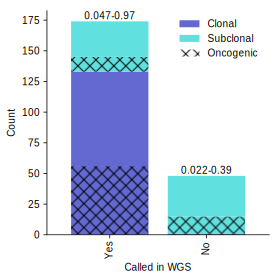

In [35]:
df = sup3.copy()
df["onco"] = df["OncoKb Oncogenicity"].str.contains(
    "onco", regex=False, case=False, na=False
)
df["IS_SUBCLONAL"] = df["Subclonal"] == "Yes"
f, ax = plt.subplots(1, 1, figsize=(4, 4))
ax = (
    df.groupby(["Called in WGS", "onco", "IS_SUBCLONAL"])
    .size()
    .unstack()
    .unstack()
    .fillna(0)
    .iloc[::-1]
    .reindex(columns=[True, False], level="onco")
    .plot.bar(
        stacked=True,
        width=0.8,
        color=["#6369D1", "#6369D1", "#60E1E0", "#60E1E0"],
        ax=ax,
    )
)
patterns = itertools.cycle(("xx", "xx", "", ""))
for bar in ax.containers:
    for patch in bar:
        patch.set_hatch(next(patterns))
for i, (_, row) in enumerate(
    df.dropna(subset=["IS_SUBCLONAL"])
    .groupby(["Called in WGS"])["IMPACT VAF"]
    .describe()
    .iloc[::-1]
    .iterrows()
):
    plt.text(
        x=i,
        y=row["count"],
        s=f"{row['min']:0.2}-{row['max']:0.2}",
        ha="center",
        va="bottom",
        fontsize=10,
    )
handles, labels = ax.get_legend_handles_labels()
h = copy(handles[0][0])
h.set_facecolor("white")
plt.legend(handles[1::2] + [h], ["Clonal", "Subclonal", "Oncogenic"], frameon=False)
sns.despine()
plt.ylabel("Count")
ax.set_xticklabels(["Yes", "No"])
plt.xlabel("Called in WGS")
display_svg()

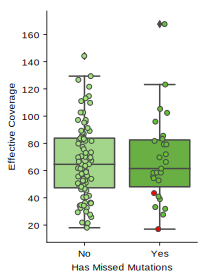

In [36]:
df = add_attr[["Individual","WGS purity","Coverage"]].copy()
df["hasMissed"] = df["Individual"].isin(sup3[~sup3["Called in WGS"]]["Individual ID"].unique())
f, ax = plt.subplots(1,1,figsize=(3,4))
df["Effective Coverage"] = df["WGS purity"]*df["Coverage"]
df["hasMissed"]=df["hasMissed"].replace({True:"Yes",False:"No"})
sns.boxplot(data=df, x='hasMissed', y="Effective Coverage",ax=ax,palette=["#9EE37D","#63C132"])
sns.stripplot(data=df, x='hasMissed', y="Effective Coverage",linewidth=1,ax=ax,palette=["#9EE37D","#63C132"])
plt.xlabel("Has Missed Mutations")
collection = ax.collections[1]
cols = []
for off, col in zip(collection.get_offsets(),collection.get_facecolors()):
    if int(off[1]) in df[df["Individual"].isin(["H136574","H196388"])]["Effective Coverage"].astype(int).values:
        cols.append("red")
    else:
        cols.append(col)
collection.set_facecolors(cols)
sns.despine()
display_svg()

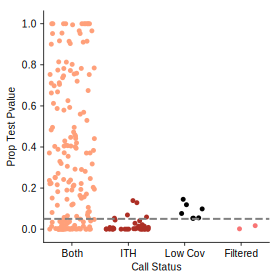

In [37]:
data = sup3.copy()
data.loc[
    (data["ITH Status"] == "Predicted ITH")
    & (data["Prop Test Corrected by Tumor purity"] >= 0.05),
    "ITH Status",
] = "Low Cov"
data["ITH Status"] = pd.Categorical(
    data["ITH Status"].replace(
        {"Predicted ITH": "ITH", "Missed": "Filtered", "Confirmed ITH": "ITH"}
    ),
    ["Both", "ITH", "Low Cov", "Filtered"],
    ordered=True,
)
f, ax = plt.subplots(1, 1, figsize=(4, 4))
melty = data.melt(
    id_vars=["Individual ID", "CHR", "START", "ITH Status"],
    value_vars="Prop Test Corrected by Tumor purity",
)
sns.stripplot(
    data=melty,
    x="ITH Status",
    y="value",
    jitter=0.4,
    palette=["#FFA07A", "#AD2E24", "black", "#F87575"],
    zorder=1,
    ax=ax,
)
plt.axhline(0.05, color="grey", zorder=10, lw=2, linestyle="--")
plt.ylabel("Prop Test Pvalue")
plt.xlabel("Call Status")
sns.despine()
display_svg()

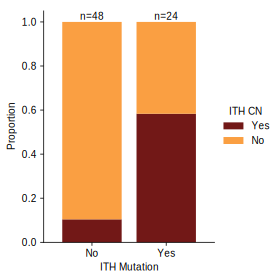

In [38]:
ith_cn = sup3.sort_values("ITH Status",ascending=False).drop_duplicates(subset=["Individual ID"])
ith_cn = ith_cn[~ith_cn["DISCREPANT CN"].isna()]
ith_cn["ITH_MUT"] = ith_cn["ITH Status"].str.contains("ITH",na=False).replace({True:"Yes",False:"No"})
ith_cn["ITH_CN"] = ith_cn["DISCREPANT CN"].apply(lambda x: "No" if x == "No" else "Yes")
ith_cn = ith_cn.groupby(["ITH_MUT","ITH_CN"]).size().unstack()
ith_cn = ith_cn.loc[["No","Yes"]].iloc[:,::-1]
ith_cn_sum = ith_cn.sum(axis=1)
f,ax=plt.subplots(1,1,figsize=(4,4))
ith_cn.div(ith_cn.sum(axis=1),axis=0).plot.bar(stacked=True,width=0.8,color=["#721817","#FA9F42"],ax=ax)
for i, count in enumerate(ith_cn_sum):
    plt.text(i,1,f"n={count}",ha="center",va="bottom")
plt.xticks(rotation=0)
plt.ylabel("Proportion")
plt.xlabel("ITH Mutation")
plt.legend(frameon=False,title="ITH CN",loc="center left",bbox_to_anchor=(1, 0.5))
sns.despine()
display_svg()

# Supplemental Figure 3

/juno/work/isabl/opt/python/.virtualenvs/users/levinem1/click_egreport/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


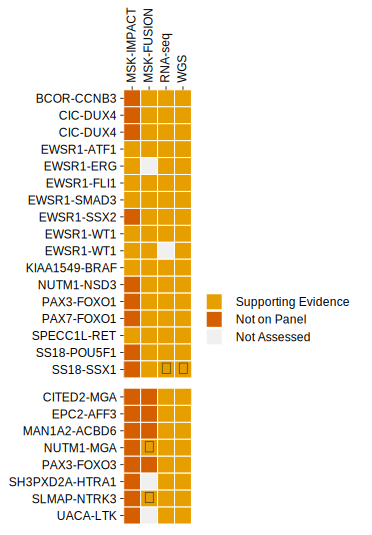

In [39]:
colors = ["#F0F0F0", "#D55E00", "#E79F00"]
fdf = (
    sup5[["Fusion", "MSK-IMPACT", "MSK-FUSION", "RNA", "DNA"]]
    .copy()
    .rename(
        columns={
            "DNA": "WGS",
            "RNA": "RNA-seq",
            "IMPACT": "MSK-IMPACT",
            "Archer": "MSK-Fusion",
        }
    )
)
fdf["group"] = 0
fdf.iloc[-8:, -1] = 1
f, (axes) = plt.subplots(
    2,
    1,
    figsize=(4, 8),
    gridspec_kw={"hspace": 0.05, "height_ratios": fdf["group"].value_counts()},
)
axes[0].xaxis.tick_top()  # x axis on top
for i, df in (
    fdf.sort_values(["group", "Fusion"])
    .set_index("Fusion")
    .groupby("group", sort=False)
):
    df = df.drop("group", axis=1)
    ax = axes[i]
    annot = df.applymap(lambda x: "∗" if x == "2*" else "")
    sns.heatmap(
        df.replace("2*", 2).astype(int),
        ax=ax,
        cmap=colors,
        cbar=False,
        square=True,
        linewidths=1,
        yticklabels=True,
        vmin=0,
        vmax=2,
        annot=annot,
        fmt="",
        annot_kws={"fontsize": 16},
    )
    plt.sca(ax)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel("")
legend_elements = [
    Line2D(
        [0],
        [0],
        markerfacecolor=x[0],
        markersize=15,
        marker="s",
        label=x[1],
        linewidth=0,
        mew=0,
    )
    for x in zip(
        reversed(colors),
        reversed(["Not Assessed", "Not on Panel", "Supporting Evidence"]),
    )
]
axes[0].legend(
    handles=legend_elements,
    frameon=False,
    fontsize=12,
    title_fontsize=14,
    loc="center left",
    bbox_to_anchor=(1, 0.2),
)
plt.xticks([])
display_svg()

# Supplemental Figure 4

In [40]:
atrx_svs = [
    "H134733",
    "H135387",
    "H158151",
    "H159153",
    "H135967",
    "H134738",
    "H158919",
    "H196807",
    "H197217",
    "H196388",
    "H158493",
    "H135463",
    "H135973",
]
atrx_small = ["H134753", "H135089", "H136632", "H158273", "H195990", "H196046"]
tert = [
    "H108333",
    "H136425",
    "H136375",
    "H136648",
    "H158183",
    "H159446",
    "H196095",
    "H136574",
    "H196390",
    "H136062",
    "H135990",
    "H159103",
]
mycn = ["H133671"]
types = nbl_types[nbl_types["type"].isin(["MYCN", "ATRX", "TERT"])]
types["Individual"] = "H" + types["Individual"].str.strip("IDH-_").str.slice(0, 6)
type_dict = types.set_index("Individual")["type"].to_dict()
for x in atrx_svs + atrx_small:
    type_dict[x] = "ATRX"
for x in tert:
    type_dict[x] = "TERT"
for x in mycn:
    type_dict[x] = "MYCN"
type_color = {"MYCN": "#009E73", "TERT": "#9ad0f3", "ATRX": "#CBC3E3", "None": "salmon"}

/juno/work/isabl/opt/python/.virtualenvs/users/levinem1/click_egreport/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/juno/work/isabl/opt/python/.virtualenvs/users/levinem1/click_egreport/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


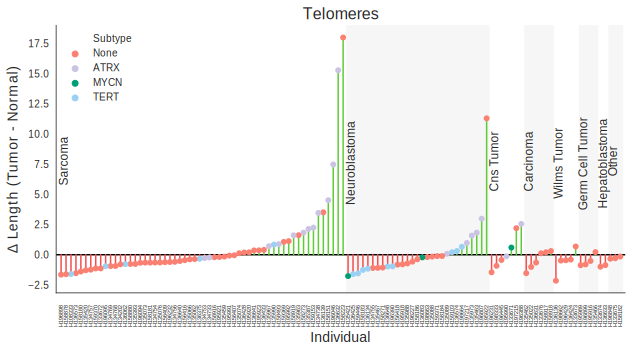

In [41]:
telomeres["Subtype"] = telomeres["Individual"].apply(lambda x: type_dict.get(x, "None"))
telomeres["Disease"] = pd.Categorical(
    telomeres["Disease"],
    categories=reversed(
        list(telomeres["Disease"].value_counts().drop("Other").index.values) + ["Other"]
    ),
    ordered=True,
)
col = itertools.cycle(["#f6f6f6", "#ffffff"])
with sns.axes_style("white"):
    fig, (ax1) = plt.subplots(1, 1, figsize=(9, 5))
    plt.axes(ax1)
    plt.axhline(0, color="black", linestyle="-", zorder=1)
    sns.scatterplot(
        data=telomeres.sort_values(["Disease", "diff"], ascending=[True, False]),
        x="Individual",
        y="diff",
        hue="Subtype",
        linewidth=0,
        zorder=2,
        ax=ax1,
        palette=type_color,
    )
    plt.xticks(fontsize=6, rotation=90)
    for _, row in telomeres.iterrows():
        color = "#5fcc37"
        if row["diff"] < 0:
            color = "#f24e4e"
        ax1.plot([row["Individual"]] * 2, [0, row["diff"]], color=color, zorder=1)
    count = -0.5
    for grp, df in (
        telomeres.sort_values(["Disease", "diff"])
        .drop_duplicates("Individual")
        .groupby("Disease")
    ):
        ax1.text(
            count + len(df),
            (telomeres["diff"].min() + telomeres["diff"].max()) / 2,
            grp,
            ha="left",
            va="center",
            fontsize=12,
            rotation=90,
        )
        ax1.axvspan(count, count + len(df), color=next(col), zorder=0)
        count += len(df)

    sns.despine(ax=ax1)
    plt.title("Telomeres", fontsize=16)
    plt.ylabel(r"$\Delta$ Length (Tumor - Normal)", fontsize=14)
    plt.xlabel("Individual", fontsize=14)
    plt.legend(frameon=False)
    plt.xlim(telomeres.shape[0], -1)
    display_svg()

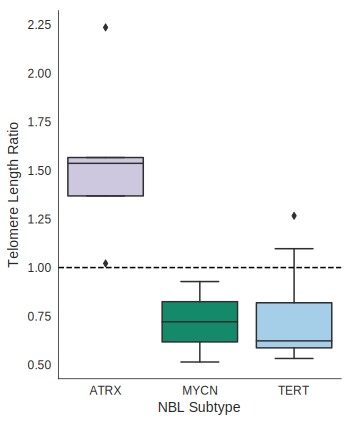

In [42]:
nbl_types["Individual"] = "H" + nbl_types["Individual"].str.strip("IDH-_").str.slice(
    0, 6
)
nbls = nbl_types.merge(telomeres, on="Individual")
type_color = {
    "MDM2-CDK4": "black",
    "MYCN": "#009E73",
    "NUM_CNV": "black",
    "SEG_CNV": "black",
    "TERT": "#9ad0f3",
    "ATRX": "#CBC3E3",
    "None": "black",
}
with sns.axes_style("white"):
    plt.figure(figsize=(5, 6))
    sns.boxplot(
        data=nbls[nbls["type"].isin(["ATRX", "MYCN", "TERT"])],
        x="type",
        y="ratio",
        palette=type_color,
    )
    plt.ylabel("Telomere Length Ratio", fontsize=14)
    plt.xlabel("NBL Subtype", fontsize=14)
    plt.axhline(1, linestyle="--", color="black")
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    sns.despine()
    display_svg()

/juno/work/isabl/opt/python/.virtualenvs/users/levinem1/click_egreport/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


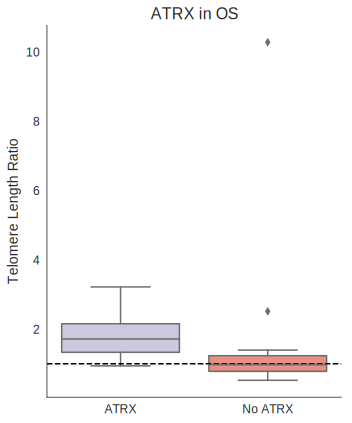

In [43]:
os = telomeres[
    telomeres["Individual"].isin(
        [
            "H134757",
            "H135076",
            "H135387",
            "H134733",
            "H135967",
            "H135990",
            "H136428",
            "H136139",
            "H136375",
            "H136641",
            "H156409",
            "H136433",
            "H158493",
            "H158273",
            "H158151",
            "H158223",
            "H134738",
            "H158880",
            "H158916",
            "H158919",
            "H159153",
            "H159369",
            "H159370",
            "H195921",
            "H195923",
            "H195992",
            "H195991",
            "H196046",
            "H196898",
        ]
    )
]
os["ATRX"] = os["Individual"].isin(
    [
        "H134738",
        "H158493",
        "H158151",
        "H158919",
        "H159153",
        "H134733",
        "H135967",
        "H135387",
        "H158273",
        "H158273",
        "H196046",
    ]
)
with sns.axes_style("white"):
    plt.figure(figsize=(5, 6))
    sns.boxplot(
        data=os, x="ATRX", y="ratio", palette=["#CBC3E3", "salmon"], order=[True, False]
    )
    plt.ylabel("Telomere Length Ratio", fontsize=14)
    plt.title("ATRX in OS", fontsize=16)
    plt.xlabel("", fontsize=14)
    plt.axhline(1, linestyle="--", color="black")
    plt.yticks(fontsize=12)
    plt.xticks([0, 1], labels=["ATRX", "No ATRX"], fontsize=12)
    sns.despine()
    display_svg()

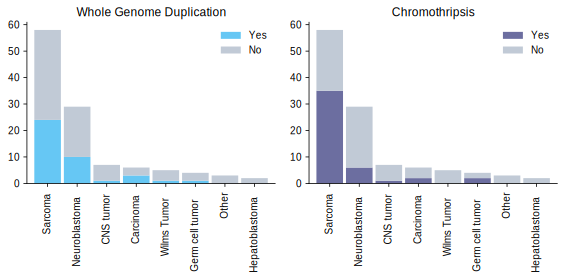

In [54]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4),sharex=True)
wgd = sup2.merge(sup1, on="Individual ID")[["Disease Category","WGD"]]
wgd["WGD"] = wgd["WGD"].fillna(0).astype(bool).replace({True:"Yes",False:"No"})
wgd = wgd.groupby(["Disease Category","WGD"]).size().unstack()
wgd.loc[wgd.sum(axis=1).sort_values(ascending=False).index,["Yes","No"]].fillna(0).plot.bar(stacked=True,width=0.9,rot=90,color=["#66C7F4","#C1CAD6"],ax=ax1)
ax1.set_xlim(-0.45,)
ax1.set_title("Whole Genome Duplication")
ax1.set_xlabel("")
ax1.legend(title="",frameon=False)
chromo = sup2.merge(sup1, on="Individual ID")[["Disease Category","Chromothripsis"]]
chromo["Chromothripsis"] = chromo["Chromothripsis"].fillna(0).astype(bool).replace({True:"Yes",False:"No"})
chromo = chromo.groupby(["Disease Category","Chromothripsis"]).size().unstack()
chromo.loc[chromo.sum(axis=1).sort_values(ascending=False).index,["Yes","No"]].fillna(0).plot.bar(stacked=True,width=0.9,rot=90,color=["#6C6EA0","#C1CAD6"],ax=ax2)
ax2.set_title("Chromothripsis")
ax2.set_xlabel("")
ax2.legend(title="",frameon=False)
sns.despine()
display_svg()

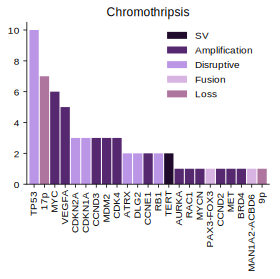

In [45]:
wgd = chromof[chromof["chromothripsis_loci"]!="none"]
wgd = [st for row in wgd["chromothripsis_loci"].str.split(",").values for st in row]
chromo = defaultdict(lambda: defaultdict(int))
for event in wgd:
    name,event = event.split("_")
    chromo[name][event]+=1
f,ax = plt.subplots(1,1,figsize=(4,4))
chromo = pd.DataFrame(chromo).T.fillna(0)
chromo.columns = ["SV"] + chromo.columns[1:].str.title().tolist()
chromo.loc[chromo.sum(axis=1).sort_values(ascending=False).index].plot.bar(stacked=True,width=0.9,ax=ax,color=["#210b2c","#55286f","#bc96e6","#d8b4e2","#ae759f"])
ax.legend(title="",frameon=False)
ax.set_title("Chromothripsis")
sns.despine()
display_svg()

# Supplemental Figure 5

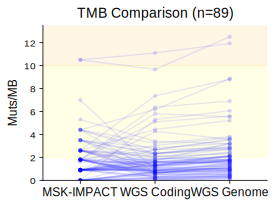

In [55]:
melty = add_attr.dropna(subset=["IMPACT TMB"]).rename(columns={"IMPACT TMB":"MSK-IMPACT","Coding TMB":"WGS Coding","TMB":"WGS Genome"}).melt(value_vars=["MSK-IMPACT","WGS Coding","WGS Genome"],id_vars="Individual",var_name="TMB",value_name="Muts/MB")
fig, ax1 = plt.subplots(1,1, sharey=True, figsize=(4,3))
for _,df in melty.groupby("Individual"):
    g = sns.pointplot(x="TMB", y="Muts/MB", color="blue", data=df,scale=0.5, ax=ax1, clip_on=False)
    plt.setp(g.collections, alpha=.1) #for the markers
    plt.setp(g.lines, alpha=.1)       #for the lines
sns.boxplot(x="TMB", y="Muts/MB", data=melty, ax=ax2)
sns.despine()
ax1.axhspan(2, 10, color='yellow', alpha=0.1, zorder=0)
ax1.axhspan(10, 100, color='orange', alpha=0.1, zorder=0)
ax1.set_ylabel("Muts/MB",fontsize=12)
ax1.set_xlabel("")
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize=12)
plt.ylim(0,melty["Muts/MB"].max()+1)
plt.title(f"TMB Comparison (n={len(melty.Individual.unique())})",y=1.01,fontsize=14)
display_svg()

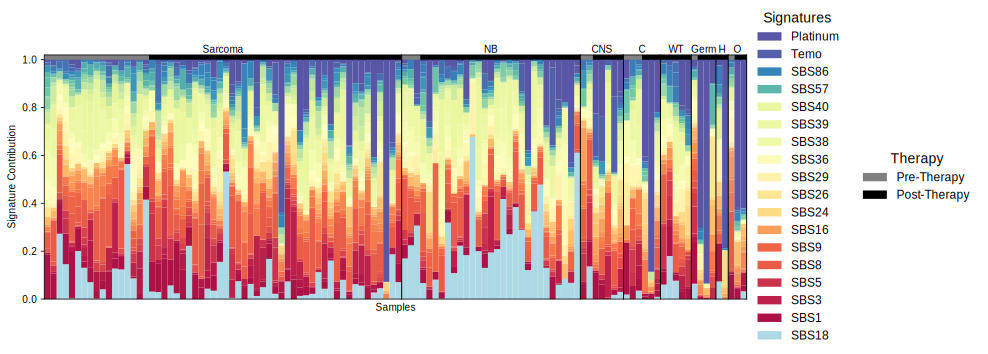

In [57]:
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(111)
normdf = signatures.copy()
normdf[normdf.columns.drop(["therapy","disease"])]=signatures.drop(["therapy","disease"],axis=1).div(signatures.drop(["therapy","disease"],axis=1).sum(axis=1),axis=0)
trans = transforms.blended_transform_factory(
    ax.transData, ax.transAxes)
count=0
for disease,i in list(signatures.groupby("disease", sort=False).size().items()):
    ldisease = {"Osteosarcoma":"OS","Neuroblastoma":"NB","Undifferentiated Sarcoma":"U. Sarcoma","Embryonal Rhabdomyosarcoma":"RMS","Wilms Tumor":"WT","Ewing Sarcoma":"EWS","Cns Tumor":"CNS","Hepatoblastoma":"H","Other":"O","Germ Cell Tumor":"Germ","Carcinoma":"C"}.get(disease,disease)
    plt.text(x=count+i/2-0.5,y=1,s=ldisease,transform = trans,ha="center",va="bottom")
    count+=i
    ax.axvline(count-0.5, color="black",lw=1)
tmap = {"PRE-THERAPY":"grey","POST-THERAPY":"black"}
count = 0
for g, val in signatures.groupby(["disease","therapy"], sort=False).size().items():
    plt.barh(1,left=count-0.5,width=val,height=0.05,color=tmap[g[1]],transform = trans)
    count+=val
cmap = [("#add8e6" if x=="SBS18" else y) for x,y in zip(signatures.drop(["therapy","disease"],axis=1).columns, sns.color_palette("Spectral",n_colors=signatures.shape[1]-2))]
normdf.drop(["therapy","disease"],axis=1).rename(columns={x:"_"+x for x in signatures.columns if x not in legsigs}).plot.bar(stacked=True,legend=True,lw=0,width=1,ax=ax,color=cmap)
plt.xlim(-0.5,count-0.5)
# plt.xticks(rotation_mode='anchor',ha="right",va="center")
plt.xticks([])
plt.xlabel("Samples")
plt.ylabel("Signature Contribution")
plt.ylim(0,1.02)
handles, labels = ax.get_legend_handles_labels()
from matplotlib.patches import Patch
leg = ax.legend([Patch(facecolor=x) for x in tmap.values()], map(str.title,tmap.keys()), title='Therapy', frameon=False,fontsize=12,title_fontsize=14,loc="center left",bbox_to_anchor=(1.15, 0.5))
ax.legend(handles[::-1], labels[::-1], title='Signatures', frameon=False,fontsize=12,title_fontsize=14,loc="center left",bbox_to_anchor=(1, 0.5))
ax.add_artist(leg)
display_svg()

In [58]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

seaborn==0.10.1
scikit-learn==0.22.1
pandas==0.24.2
numpy==1.16.3
matplotlib==3.0.3
